In [1]:
#| code-fold: true

import os
os.chdir("/project/persistent-exclusion-process")

import glob

import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition, inset_axes
import numpy as np
from cmcrameri import cm
from scipy import ndimage
import pandas as pd

from src.plot_utils import get_plot_configs
from src.stringato import extract_floats
from src.utils import get_ds_iters, get_cluster_labels

In [1]:
#| code-fold: true

def save_points():
    files = sorted(glob.glob("bp_data/dataset*"))
    stuff = []
    for file in files:
        tumble = float(extract_floats(file)[0])
        density = float(extract_floats(file)[1])
        stuff.append((tumble, density))
    all_alphas, all_phis, all_bin_edges, all_counts = [], [], [], []
    kernel = [[0, 1, 0], [1, 1, 1], [0, 1, 0]]
    for idx in range(3):
        for jdx in range(3):
            ctr = idx*3 + jdx
            hf = h5py.File(files[ctr], "r")
            key_list = list(hf.keys())
            iters = get_ds_iters(key_list)
            all_cs = np.array([])
            for iter in range(len(iters)):
                im = hf[f"conf_{iters[iter]}"]
                labelled, _ = ndimage.label(im, structure=kernel)
                cluster_sizes = np.bincount(labelled.flatten())[1:]
                all_cs = np.hstack((all_cs,cluster_sizes))
            min_c = np.min(all_cs)
            max_c = np.max(all_cs)
            bin_edges = np.logspace(np.log2(min_c), np.log2(max_c), 32, base=2)
            counts, _ = np.histogram(
                all_cs, bins=bin_edges, density=True
            )
            all_alphas.append(stuff[ctr][0])
            all_phis.append(stuff[ctr][1])
            all_bin_edges.append(bin_edges[:-1].tolist())
            all_counts.append(counts.tolist())
    csv_out = pd.DataFrame()
    csv_out.insert(0, "alphas", all_alphas)
    csv_out.insert(1, "phis", all_phis)
    csv_out.insert(2, "bin edges", all_bin_edges)
    csv_out.insert(3, "counts", all_counts)
    name = "csize_avg"
    csv_out.to_csv(f"plots/{name}.csv")

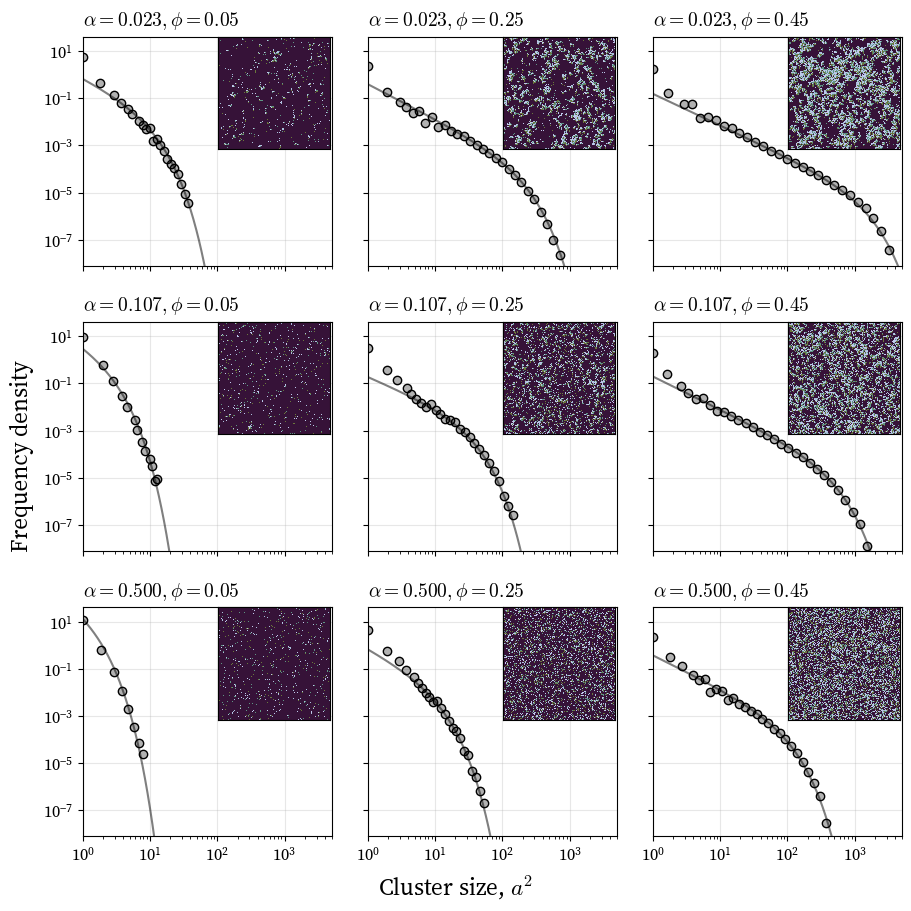

In [3]:
#| code-fold: true
import warnings
warnings.filterwarnings("ignore")

def func(x, a, b, c):
    return c*x**(-a)*np.e**(-x/b)

x_lim = (1, 5e3)
x = np.logspace(np.log10(x_lim[0]),np.log10(x_lim[1]),500,base=10)
files = sorted(glob.glob("bp_data/dataset*"))
stats = pd.read_csv("plots/csize_avg.csv")
fits = pd.read_csv("plots/fit_values.csv")
plot_configs = get_plot_configs()
plot_configs["xtick.labelsize"] = 12
plot_configs["ytick.labelsize"] = 12
plt.rcParams.update(plot_configs)
fig = plt.figure(figsize=(9, 9), constrained_layout=True)
gspec = fig.add_gridspec(3, 3, wspace=0.08, hspace=0.08)
cmap = plt.get_cmap(name="cmc.glasgowS", lut=5)
text_kwrgs = {"ha": "left", "fontsize": "medium", "fontfamily": "serif"}
for idx in range(3):
    for jdx in range(3):
        ctr = idx*3 + jdx
        axis = fig.add_subplot(gspec[idx, jdx])
        axins = inset_axes(axis, width="100%", height="100%", borderpad=1)
        axins.set_axes_locator(InsetPosition(axis, [0.525, 0.51, 0.49, 0.49]))
        text_kwrgs["s"] = r"$\alpha = {:.3f}, \phi = {:.2f}$".format(
            stats["alphas"][ctr], stats["phis"][ctr]
        )
        hf = h5py.File(files[ctr], "r")
        key_list = list(hf.keys())
        iters = get_ds_iters(key_list)
        img = hf[f"conf_{iters[-1]}"]
        axins.matshow(img, cmap=cmap)
        axins.set_yticks([])
        axins.set_xticks([])
        axis.plot(
            x,
            func(x, fits["a"][ctr], fits["b"][ctr], fits["c"][ctr]),
            color="k",
            alpha=0.5,
            zorder=1
        )
        axis.scatter(
            list(map(float,stats["bin edges"][ctr][1:-1].split(","))),
            list(map(float,stats["counts"][ctr][1:-1].split(","))),
            edgecolor=(0, 0, 0, 1),
            facecolor=(0, 0, 0, 0.3),
            zorder=2
        )
        axis.grid(alpha=.3)
        axis.set_axisbelow(True)
        axis.set_yscale("log"), axis.set_xscale("log")
        axis.text(
            y=1.05,
            x=0,
            transform=axis.transAxes,
            **text_kwrgs,
        )
        axis.set_ylim((8e-9, 4e1))
        axis.set_xlim(x_lim)
        # axis.set_yticks([10**idx for idx in range(-8, 2, 2)])
        # axis.set_xticks([10**idx for idx in range(0, 5)])
        fig.supxlabel(r"Cluster size, $a^{2}$")
        fig.supylabel("Frequency density")
        if jdx != 0:
            axis.set_yticklabels([])
        if idx != 2:
            axis.set_xticklabels([])
name = "csize_avg"
plt.show()
fig.savefig(f"plots/{name}.pdf", bbox_inches="tight")
fig.savefig(f"plots/{name}.png", bbox_inches="tight")